In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
def load_curves_and_preds(name_run):

    curvas = np.load(f"../resultados/{name_run}\curvas.npy", allow_pickle=True).item()

    results = np.load(f"../resultados/{name_run}/test_results.npz")
    preds = torch.tensor(results["preds"])
    targets = torch.tensor(results["targets"])

    return curvas, preds, targets

In [18]:
resultados = {
              "Baseline Sersic OIDS": load_curves_and_preds("baseline_sersic_oids"),
              "Augmented dataset[x30] BS 40 Sersic OIDS": load_curves_and_preds("augmented_dataset_x30_sersic_oids"),
              "Augmented dataset[x30] BS 256 Sersic OIDS": load_curves_and_preds("augmented_dataset_x30_sersic_oids_bs256"),
              "Augmented dataset[x30] BS 512 Sersic OIDS": load_curves_and_preds("augmented_dataset_x30_sersic_oids_bs512"),

              }

### Functions

In [8]:
def curves_comparisson(resultados, experiments):
    """
    Muestra dos subplots: uno con curvas de entrenamiento y otro con curvas de validación
    para un subconjunto de experimentos en el diccionario `resultados`.

    Args:
        resultados (dict): Diccionario donde cada key es el nombre del experimento y cada valor es
                           una tupla (curvas, preds, targets).
        experiments (list of str): Lista de keys dentro de `resultados` que se desean graficar.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    for key in experiments:
        curvas, _, _ = resultados[key]
        epochs = np.arange(len(curvas["train_loss"])) + 1
        ax1.plot(epochs, curvas["train_loss"], label=key)
        ax2.plot(epochs, curvas["val_loss"], label=key)

    ax1.set_title("Training Loss")
    ax2.set_title("Validation Loss")

    for ax in [ax1, ax2]:
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.legend()

    plt.tight_layout()
    plt.show()

In [9]:
def get_mse_df_from_resultados(resultados):
    """
    Calcula el MSE por transformación para cada experimento del diccionario `resultados`.

    Args:
        resultados (dict): Diccionario donde cada valor es una tupla (curvas, preds, targets).

    Returns:
        pd.DataFrame: DataFrame con los experimentos como filas y los MSE por transformación como columnas.
    """
    mse = torch.nn.MSELoss()
    
    transformations = {
        0: "Original",
        1: "Rotation 90°",
        2: "Rotation 180°",
        3: "Rotation 270°",
        4: "Horizontal Flip",
        5: "HF + Rot 90°",
        6: "HF + Rot 180°",
        7: "HF + Rot 270°",
    }

    data = []

    for name, (_, preds, targets) in resultados.items():
        row = {}
        for pos, trans_name in transformations.items():
            row[trans_name] = mse(targets[:, pos, :], preds[:, pos, :]).item()
        row["Experimento"] = name
        data.append(row)

    df = pd.DataFrame(data)
    df = df.set_index("Experimento")
    return df

In [12]:
3732/60

62.2

### Curves

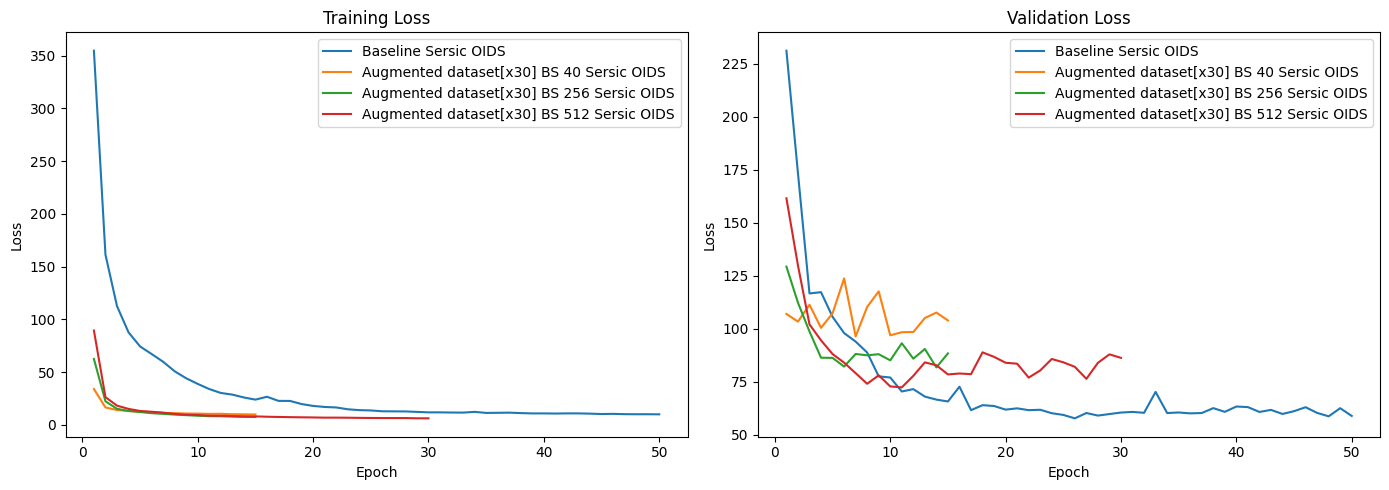

In [19]:
curves_comparisson(resultados, experiments=["Baseline Sersic OIDS",
                                            "Augmented dataset[x30] BS 40 Sersic OIDS",
                                            "Augmented dataset[x30] BS 256 Sersic OIDS",
                                            "Augmented dataset[x30] BS 512 Sersic OIDS"])

### Metrics

In [20]:
df_metrics = get_mse_df_from_resultados(resultados)
df_metrics

,Original,Rotation 90°,Rotation 180°,Rotation 270°,Horizontal Flip,HF + Rot 90°,HF + Rot 180°,HF + Rot 270°
Experimento,,,,,,,,
Baseline Sersic OIDS,78.497780,80.156769,78.503716,78.990906,79.275200,82.617874,77.633987,78.837349
Augmented dataset[x30] BS 40 Sersic OIDS,135.822021,136.759933,130.763306,143.156296,130.518112,134.810745,133.303055,137.795914
Augmented dataset[x30] BS 256 Sersic OIDS,117.637283,117.566589,117.287109,120.868118,116.923035,120.276001,121.438934,117.956154
Augmented dataset[x30] BS 512 Sersic OIDS,101.975563,104.946831,105.954056,102.678101,102.743324,102.600227,103.580093,104.995613
